# Regressão - Previsão do valor de um ativo no dia seguinte

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

Usamos a biblioteca **yfinance** para baixar dados históricos de ações da Apple (AAPL) dos últimos 10 anos. O dataset contém dados diários de preços (abertura, máxima, mínima, fechamento) e volume negociado.

In [ ]:
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.ticker import FuncFormatter
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

# baixar dados da Apple dos últimos 10 anos
df = yf.download("AAPL", period="10y", interval="1d", auto_adjust=True)
print("Shape:", df.shape)
df.head()

In [2]:
# remover nível de ticker se presente (robusto)
if isinstance(df.columns, pd.MultiIndex):
    for lvl in range(df.columns.nlevels):
        # se a camada for constante (ex.: todos 'AAPL'), removemos essa camada
        if df.columns.get_level_values(lvl).nunique() == 1:
            df.columns = df.columns.droplevel(lvl)
            break
print("Columns after flattening:", df.columns.tolist())


Columns after flattening: ['Close', 'High', 'Low', 'Open', 'Volume']


# 2. Data set - Explicação

O `DataFrame` `df` reúne cotações diárias da Apple (ticker `AAPL`) obtidas via `yfinance` para os últimos 10 anos (`period="10y"`, `interval="1d"`). A coluna de índice (`Date`) marca cada pregão. A partir das séries básicas (`Open`, `High`, `Low`, `Close`, `Volume`) derivaram‑se as features abaixo:

- `Price_Range`: `High - Low`. Medida de volatilidade intraday.  
- `Price_Change`: `Close - Open`. Variação diária absoluta (momentum do dia).  
- `High_Low_Ratio`: `High / Low`. Proporção de amplitude do dia (volatilidade relativa).  
- `Return_1d`, `Return_3d`, `Return_5d`, `Return_10d`: retornos percentuais em janelas 1/3/5/10 dias. Capturam momentum em diferentes horizontes.  
- `MA_5`, `MA_10`, `MA_20`, `MA_50`: médias móveis do preço de fechamento (suavização de tendência).  
- `Volatility_5`, `Volatility_10`, `Volatility_20`: desvio padrão móvel do fechamento (risco/instabilidade em janelas distintas).  
- `Volume_MA_5`, `Volume_MA_10`: médias móveis do volume (interesse de mercado suavizado).  
- `BB_Middle`, `BB_Upper`, `BB_Lower`, `BB_Width`: bandas de Bollinger (MA_20 ± 2·Volatility_20) e largura (volatilidade implícita).  
- `RSI`: índice de força relativa (14 dias), indicador de sobrecompra/sobrevenda.  
- `MACD`, `MACD_Signal`, `MACD_Histogram`: MACD (EMA12−EMA26), sua linha de sinal (EMA9) e histograma (força do momentum).  
- `Momentum_5`, `Momentum_10`: diferença absoluta do fechamento em 5 e 10 dias (velocidade da variação).  
- `ROC_5`, `ROC_10`: rate of change (%) em 5 e 10 dias (retorno percentual em diferentes janelas).  
- `Target`: `Close.shift(-1)` — preço de fechamento do próximo dia (variável alvo).

Essas features procuram capturar preço, volume, volatilidade e momentum em múltiplas escalas temporais. O objetivo é treinar uma rede neural capaz de estimar o preço de fechamento (`Close`) do dia seguinte a partir desse histórico.

Ainda, vale notar que todos os dados (features + target) são numéricos continuos

## Criação de novas features

In [3]:
print("\n CRIANDO FEATURES AVANÇADAS...")

# Features baseadas em preço
df['Price_Range'] = df['High'] - df['Low']  # Volatilidade intraday
df['Price_Change'] = df['Close'] - df['Open']  # Mudança diária
df['High_Low_Ratio'] = df['High'] / df['Low']  # Razão high/low

# Retornos percentuais
df['Return_1d'] = df['Close'].pct_change(1)  # Retorno de 1 dia
df['Return_3d'] = df['Close'].pct_change(3)  # Retorno de 3 dias
df['Return_5d'] = df['Close'].pct_change(5)  # Retorno de 5 dias
df['Return_10d'] = df['Close'].pct_change(10)  # Retorno de 10 dias

# Médias móveis
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Desvio padrão móvel (volatilidade)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Média móvel do volume
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

# Bandas de Bollinger (simplificadas)
df['BB_Middle'] = df['MA_20']
df['BB_Upper'] = df['MA_20'] + 2 * df['Volatility_20']
df['BB_Lower'] = df['MA_20'] - 2 * df['Volatility_20']
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

# RSI simplificado (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# Features de momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Rate of Change (ROC)
df['ROC_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)) * 100
df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

# Target: Preço de fechamento do próximo dia
df['Target'] = df['Close'].shift(-1)

print(f"Shape final após feature engineering: {df.shape}")
print(f"Total de features criadas: {df.shape[1] - 3}")  # -3 para Date, Close original e Target


 CRIANDO FEATURES AVANÇADAS...
Shape final após feature engineering: (2515, 34)
Total de features criadas: 31


## Crescimento da ação ao longo do tempo

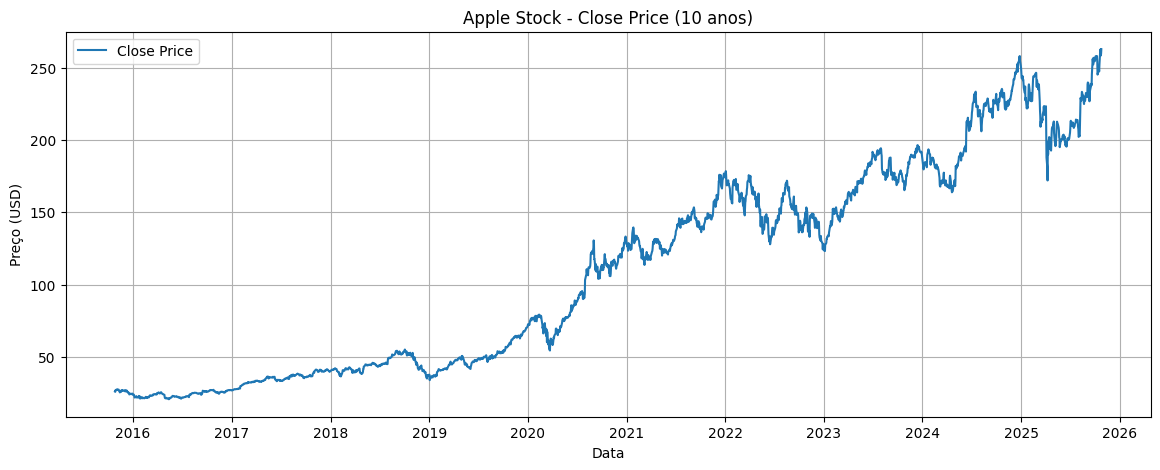

In [4]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

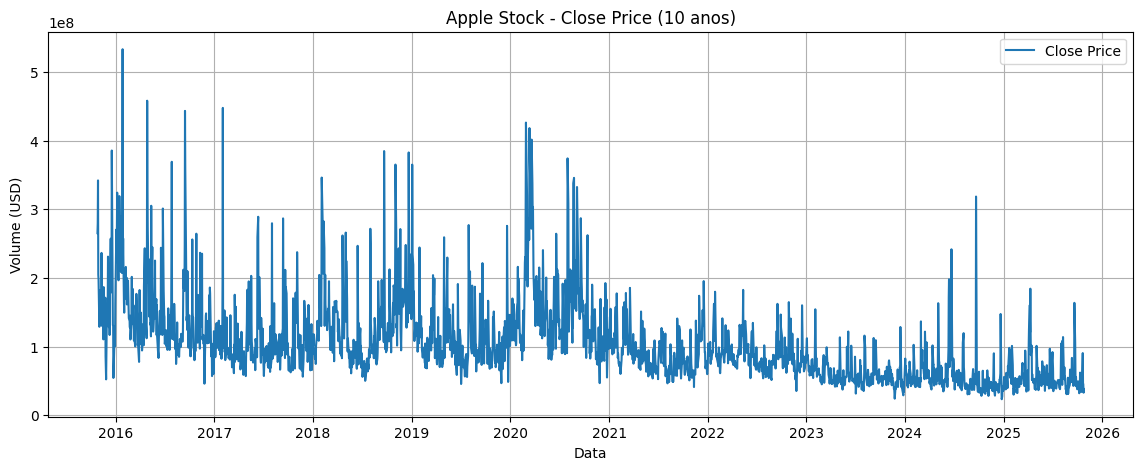

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Volume'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Volume (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Colunas com valores faltando

In [6]:
print("Valores faltantes por coluna:\n", df.isnull().sum())
df = df.dropna()

Valores faltantes por coluna:
 Price
Close              0
High               0
Low                0
Open               0
Volume             0
Price_Range        0
Price_Change       0
High_Low_Ratio     0
Return_1d          1
Return_3d          3
Return_5d          5
Return_10d        10
MA_5               4
MA_10              9
MA_20             19
MA_50             49
Volatility_5       4
Volatility_10      9
Volatility_20     19
Volume_MA_5        4
Volume_MA_10       9
BB_Middle         19
BB_Upper          19
BB_Lower          19
BB_Width          19
RSI               13
MACD               0
MACD_Signal        0
MACD_Histogram     0
Momentum_5         5
Momentum_10       10
ROC_5              5
ROC_10            10
Target             1
dtype: int64


In [7]:
print("Valores faltantes por coluna:\n", df.isnull().sum())

Valores faltantes por coluna:
 Price
Close             0
High              0
Low               0
Open              0
Volume            0
Price_Range       0
Price_Change      0
High_Low_Ratio    0
Return_1d         0
Return_3d         0
Return_5d         0
Return_10d        0
MA_5              0
MA_10             0
MA_20             0
MA_50             0
Volatility_5      0
Volatility_10     0
Volatility_20     0
Volume_MA_5       0
Volume_MA_10      0
BB_Middle         0
BB_Upper          0
BB_Lower          0
BB_Width          0
RSI               0
MACD              0
MACD_Signal       0
MACD_Histogram    0
Momentum_5        0
Momentum_10       0
ROC_5             0
ROC_10            0
Target            0
dtype: int64


### Foi utilizado um dropna, pois em algumas features, por exemplo, Momentum5 as 4 primeiras linhas não tem significado, já que é impossível calcular o valor

ARRUMAR TEXTO DEPOIS

## Visualizando as features

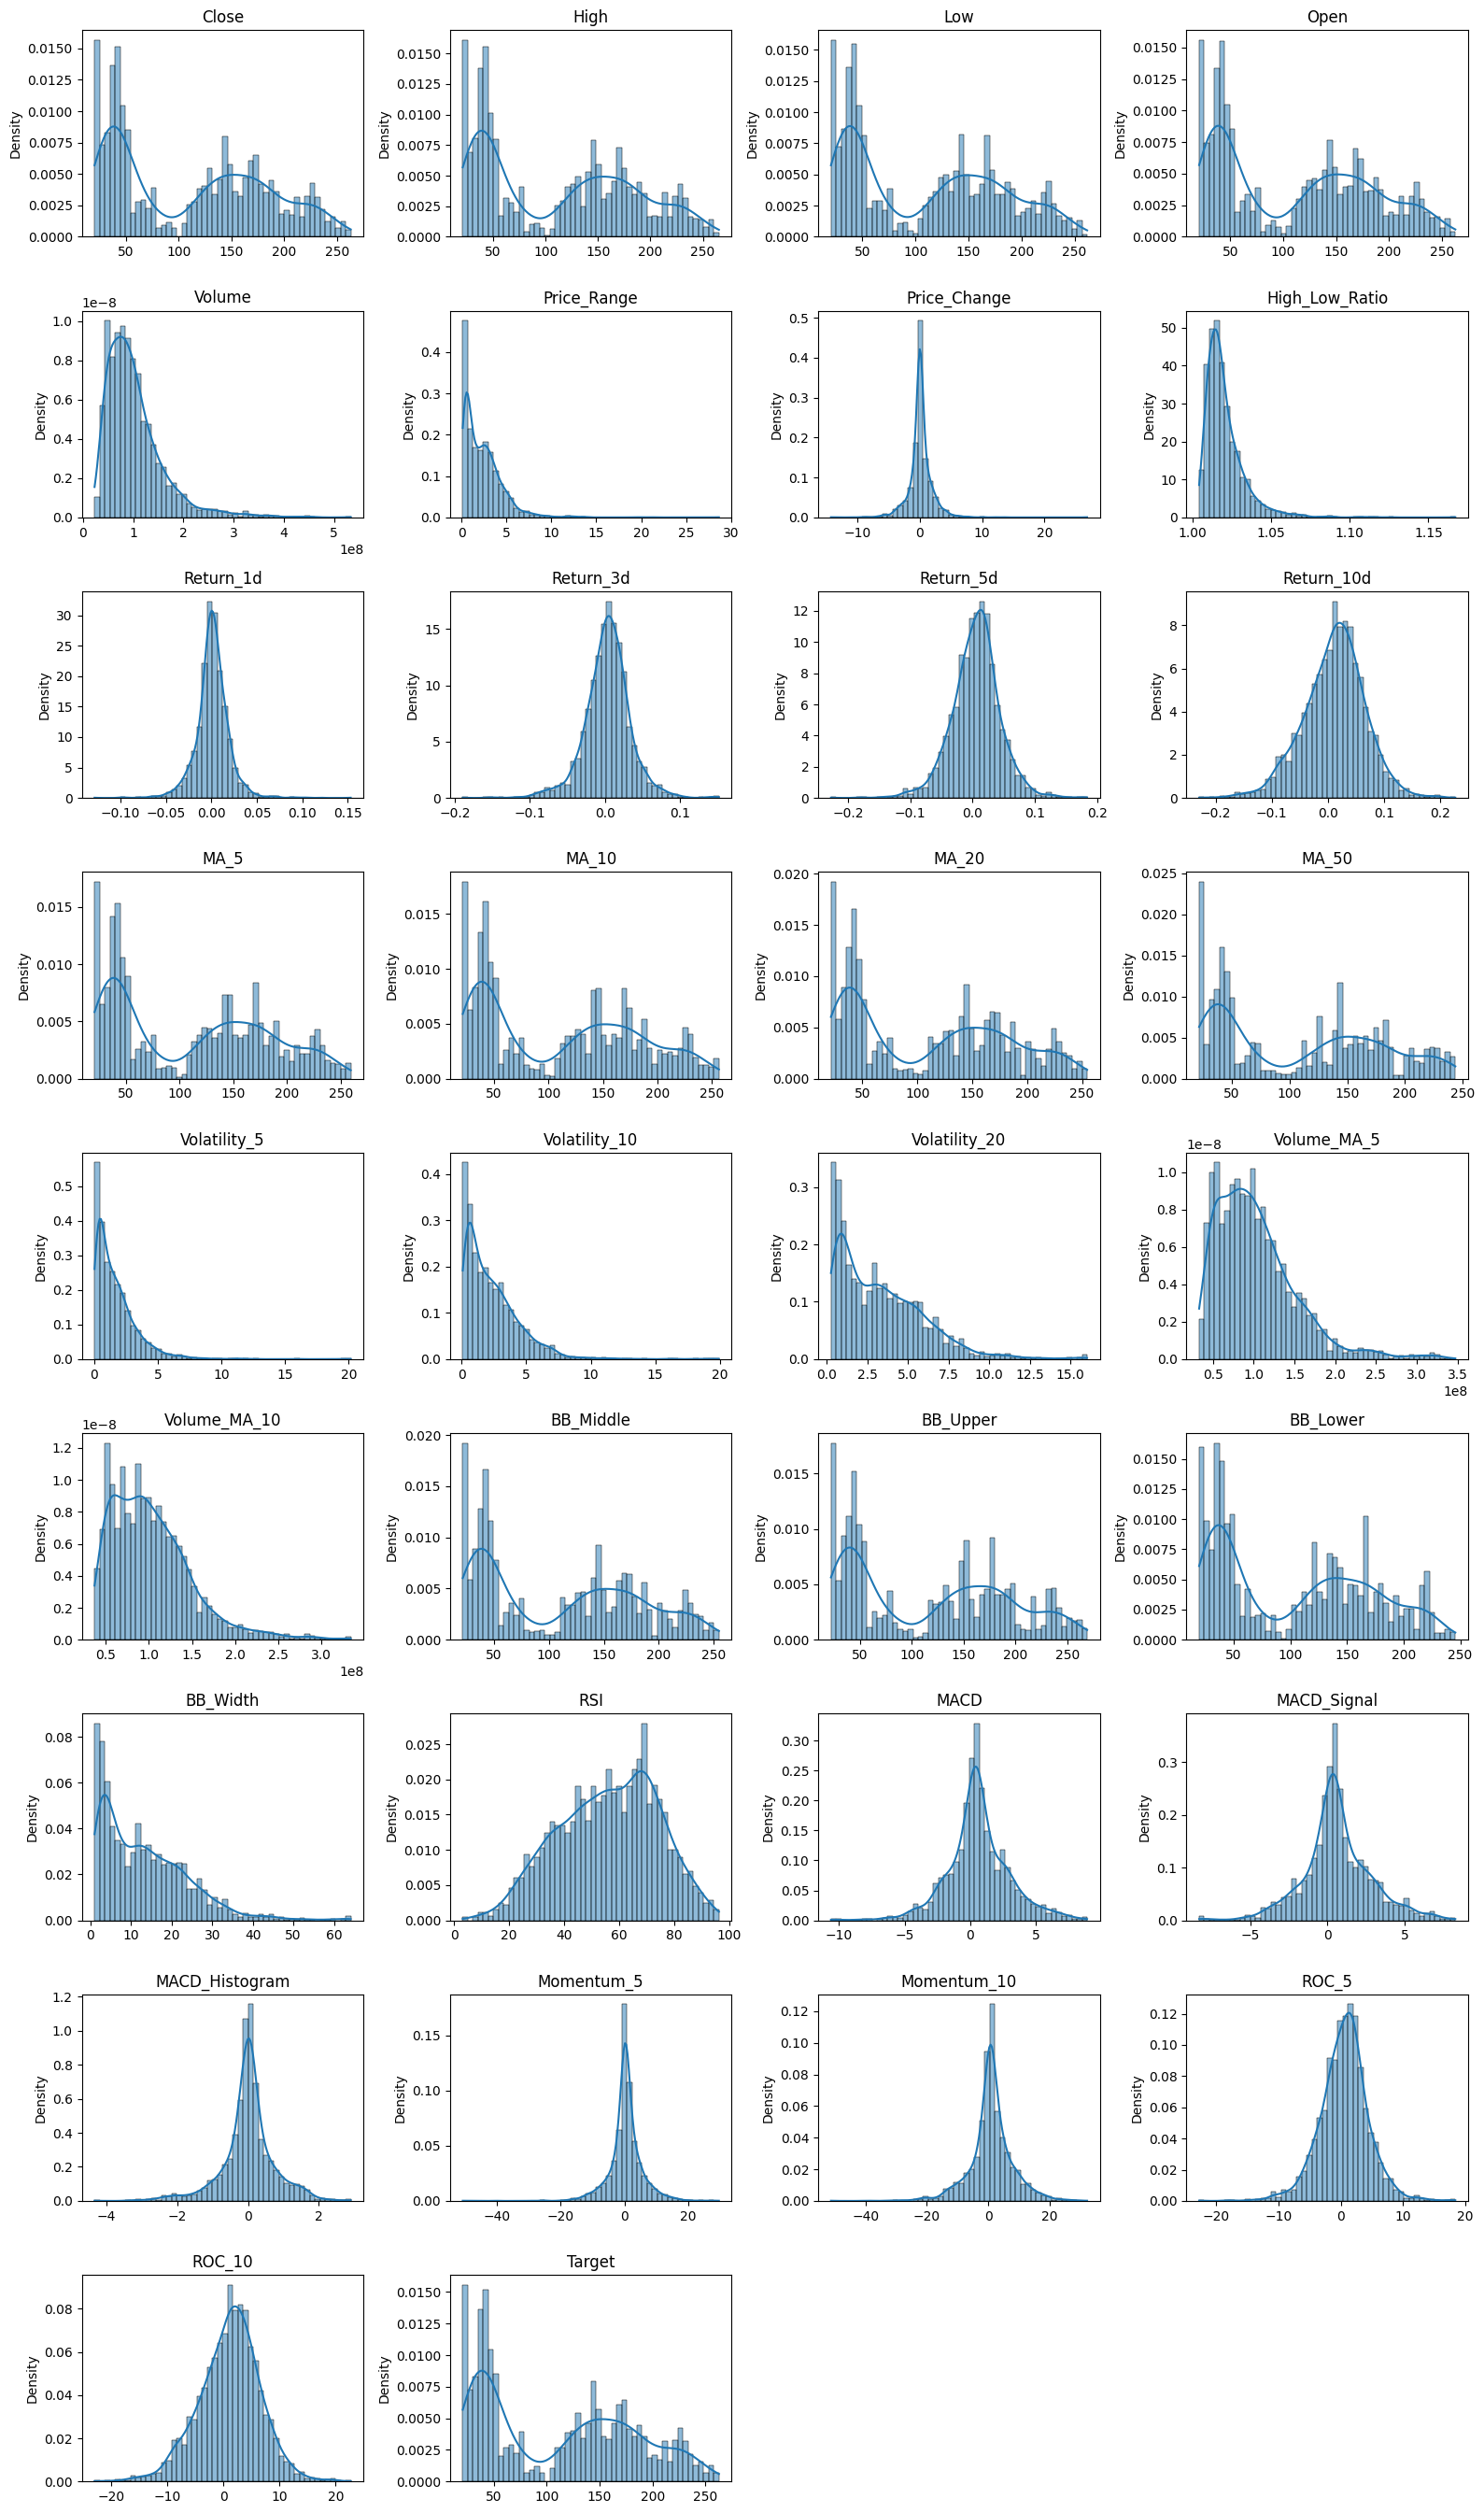

In [8]:
# Configura grid de subplots
n_cols = 4
n_features = len(df.columns)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    # remove NaNs antes de plotar
    data = df[col].dropna()
    if data.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(col)
        ax.set_axis_off()
        continue
    sns.histplot(data, bins=50, kde=True, ax=ax, stat='density', color='tab:blue')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Desativa eixos extras se houver
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

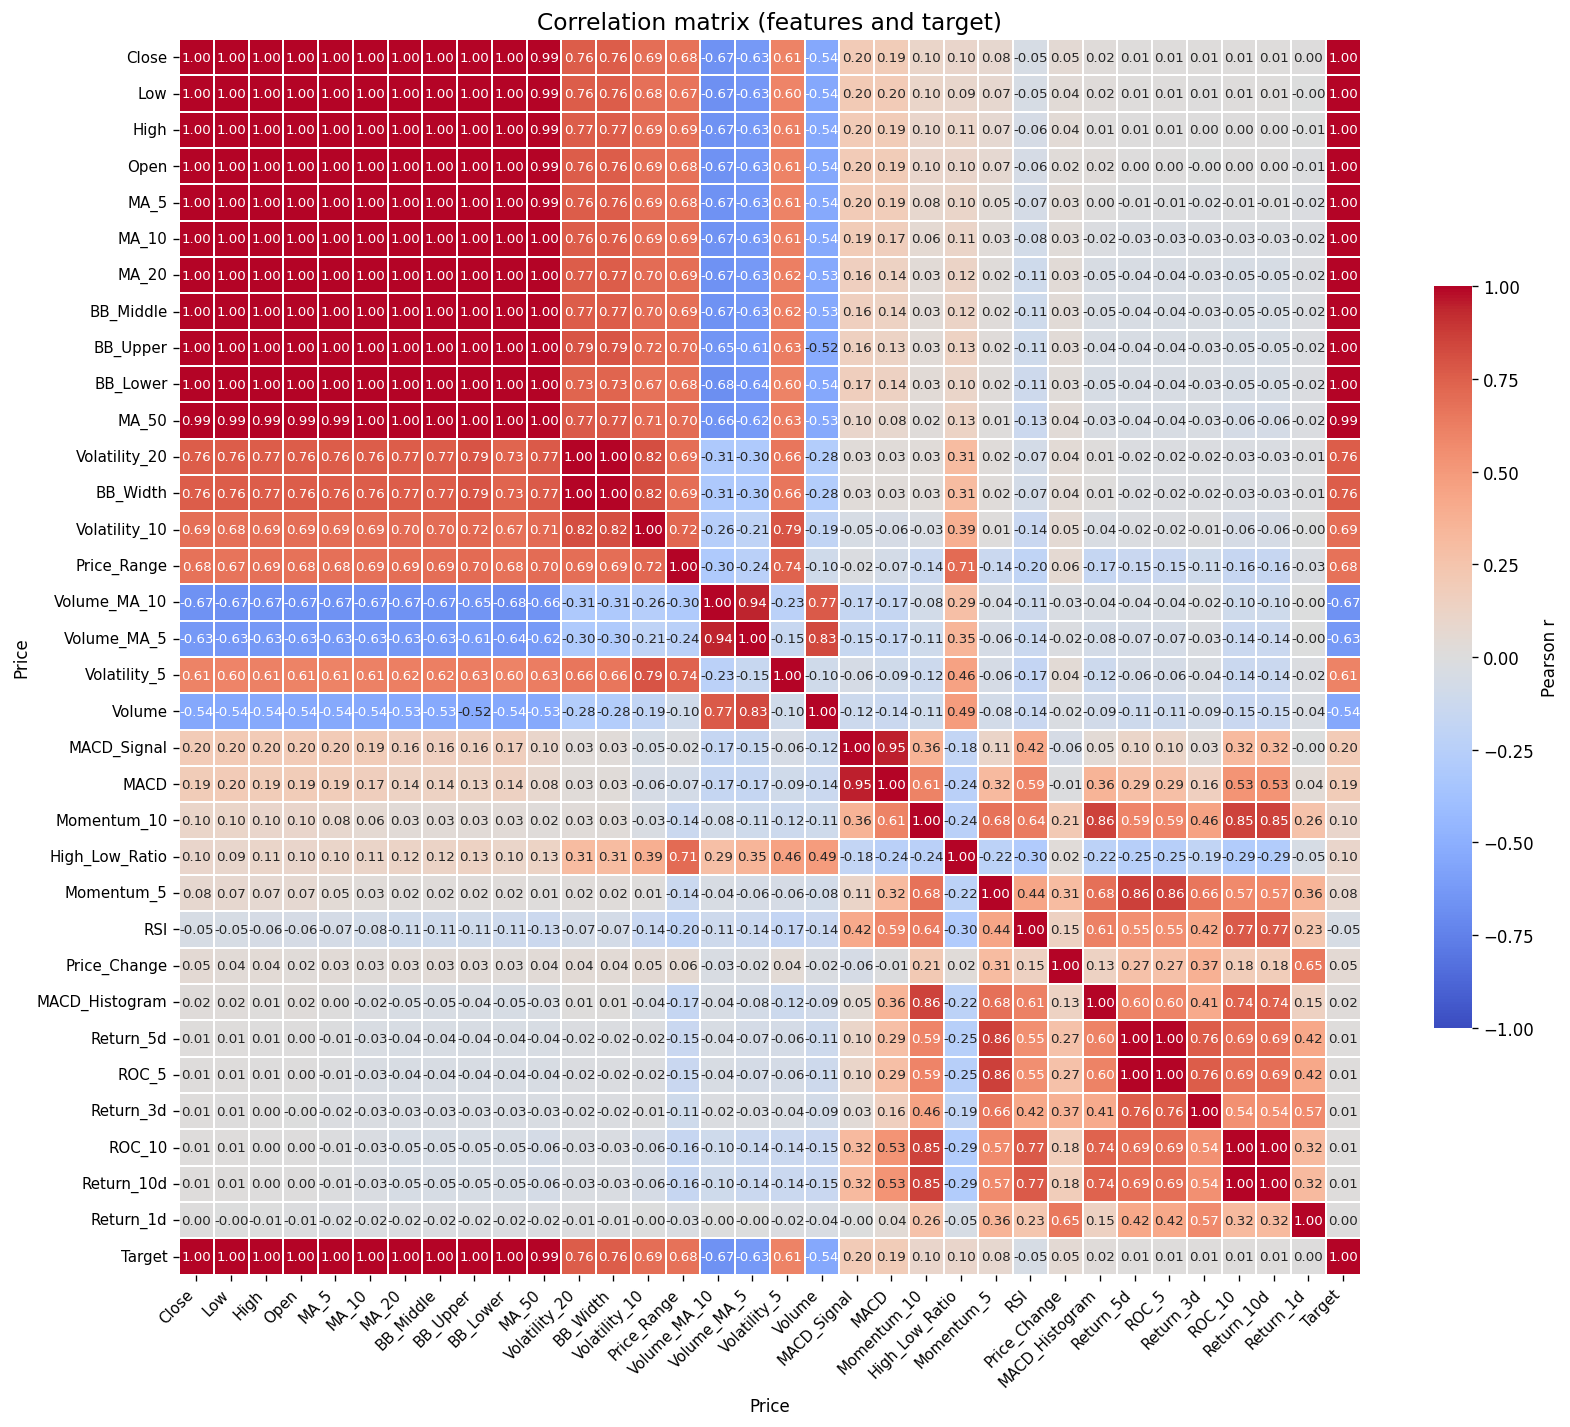


Top features por correlação (com sinal) com Target:


,corr_with_target
Price,
Close,0.999
Low,0.999
High,0.999
Open,0.999
MA_5,0.999
MA_10,0.998
MA_20,0.997
BB_Middle,0.997
BB_Upper,0.996



Média e desvio padrão das variáveis numéricas:


,mean,std
Price,,
Close,111.4397,70.6981
High,112.5501,71.3794
Low,110.2107,69.9294
Open,111.3314,70.6237
Volume,102733762.8398,57807883.1952
Price_Range,2.3393,2.1404
Price_Change,0.1083,1.9299
High_Low_Ratio,1.0205,0.0126
Return_1d,0.0012,0.0184


In [9]:
pd.options.display.float_format = '{:.3f}'.format

corr_df = df.corr()

order = corr_df['Target'].abs().sort_values(ascending=False).index.tolist()
# opcional: colocar o target no final para melhor leitura
order = [c for c in order if c != 'Target'] + ['Target']
corr_df = corr_df.loc[order, order]

# Plot heatmap com layout melhorado
plt.figure(figsize=(14, 12), dpi=120)
sns.heatmap(
    corr_df,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={'size':8},
    linewidths=0.25,
    cbar_kws={'shrink':0.6, 'label':'Pearson r'}
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Correlation matrix (features and target)', fontsize=14)
plt.tight_layout()
plt.show()

top = corr_df['Target'].drop(index='Target').sort_values(key=lambda s: s.abs(), ascending=False)
print('\nTop features por correlação (com sinal) com Target:')
display(top.to_frame(name='corr_with_target'))

# Estatísticas descritivas: média e desvio padrão
stats = df.agg(['mean', 'std']).T
stats = stats.rename(columns={'mean':'mean','std':'std'})
print('\nMédia e desvio padrão das variáveis numéricas:')
display(stats.style.format('{:.4f}'))

# 3. Limpeza & Normalização

### Abordagem: realizar um teste de hipótese e verificar normalidade de função, caso ela seja, utilizamos normalização z-score, caso não é min-max.

### Teste de D'agostin e Pearson -> p-valor baixo: não normal (min-max) / p-valor alto: possivelmente normal, plotar histograma e vizualizar o caso

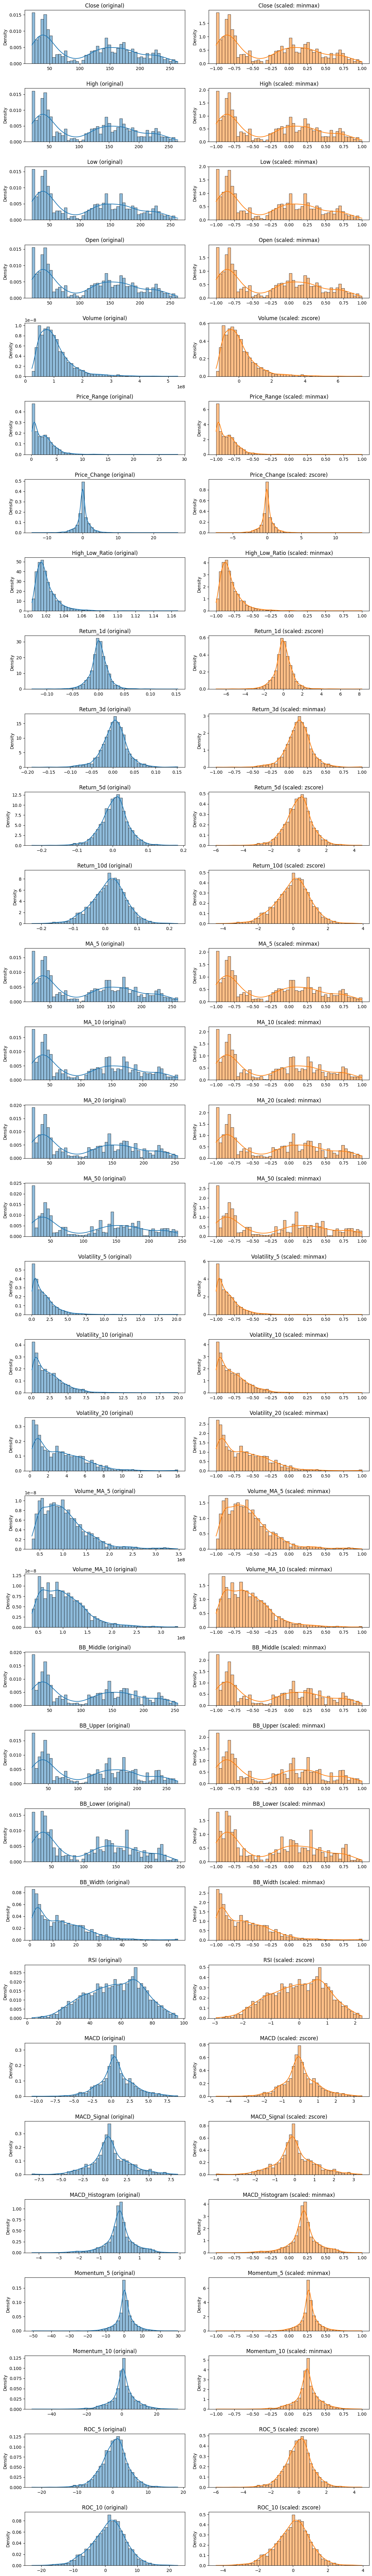

In [10]:
alpha = 0.02

df_orig = df.copy()

# decidir tipo de scaler usando uma amostra do dataset inteiro
sample = df.sample(n=min(1000, len(df)), random_state=42)

applied = {}

for col in df.columns:
    if col != 'Target':
        vals_sample = sample[col].values.reshape(-1, 1).astype(float)

        stat, p = normaltest(vals_sample[:100].ravel())

        if p >= alpha:
            scaler = StandardScaler()
            choice = "zscore"
        else:
            scaler = MinMaxScaler(feature_range=(-1,1))
            choice = "minmax"

        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).ravel()

        applied[col] = choice

cols = list(df.columns)
n_features = len(cols)-1


fig, axes = plt.subplots(n_features, 2, figsize=(12, 2.5 * n_features))
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    if c != "Target":
        ax_orig = axes[i, 0]
        ax_scaled = axes[i, 1]

        data_orig = df_orig[c]
        data_scaled = df[c]

        # plot original
        sns.histplot(data_orig, bins=50, kde=True, ax=ax_orig, stat="density", color="tab:blue")
        ax_orig.set_title(f"{c} (original)")
        ax_orig.set_xlabel("")
        ax_orig.set_ylabel("Density")

        # plot scaled
        sns.histplot(data_scaled, bins=50, kde=True, ax=ax_scaled, stat="density", color="tab:orange")
        choice_label = applied.get(c, "?")
        ax_scaled.set_title(f"{c} (scaled: {choice_label})")
        ax_scaled.set_xlabel("")
        ax_scaled.set_ylabel("Density")

plt.tight_layout()
plt.show()


# 4. Implementação MLP

### Só falar do mlp.py

# 5. Treinando o modelo

In [11]:
n = len(df)
split_at = int(n * 0.7)
train = df.iloc[:split_at].copy()
test = df.iloc[split_at:].copy()

print(f"Full shape: {df.shape}")
print(f"Train rows: {len(train)}, Test rows: {len(test)}")

Full shape: (2465, 34)
Train rows: 1725, Test rows: 740


In [ ]:
features = [c for c in train.columns if c != "Target"]

X_train = train[features].values.astype(float)
y_train = train["Target"].values.astype(float)

X_test = test[features].values.astype(float)
y_test = test["Target"].values.astype(float)

model = mlp(
    n_features=X_train.shape[1],
    n_hidden_layers=3,
    n_neurons_per_layer=[64, 32, 16, 1],
    activation="relu",
    loss="mse", # como é uma regressão utilizaremos mse
    optimizer="gd",
    epochs=200,
    eta=1e-4
)

model.train(X_train, y_train)


=== Inicialização de Pesos e Biases ===
Camada 1:
W1 shape (64, 33):
[[ 0.04282802 -0.09715661  0.06677351 ... -0.04901749  0.01770263
   0.10670865]
 [ 0.09041918  0.15029131  0.01070428 ...  0.09596759  0.02523347
   0.08421949]
 [ 0.02295138  0.06131871  0.04631448 ...  0.10980933 -0.06477457
  -0.08059715]
 ...
 [ 0.17327454 -0.01327576 -0.03682787 ...  0.02942032  0.03120605
  -0.0585885 ]
 [ 0.01514645  0.1122287   0.10429605 ... -0.01667259  0.02918213
   0.13789812]
 [-0.01779969  0.06255654  0.15422973 ... -0.21799912  0.14971698
   0.03552271]]
b1 shape (64,):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Camada 2:
W2 shape (32, 64):
[[-0.06529303  0.00363355 -0.10486936 ...  0.03847936 -0.00905023
  -0.02939684]
 [ 0.04399375 -0.15621461 -0.06165988 ...  0.13879379 -0.10272755
   0.09914791]
 [-0.17210901 -0.13349518 -0.05213

Epoch 0, Loss: 1171.970997, Train Acc: 0.00%
Epoch 10, Loss: 13.840857, Train Acc: 0.00%
Epoch 20, Loss: 15.958915, Train Acc: 0.00%
Epoch 30, Loss: 16.852063, Train Acc: 0.00%
Epoch 40, Loss: 25.444832, Train Acc: 0.00%
Epoch 50, Loss: 94.708100, Train Acc: 0.00%
Epoch 60, Loss: 19.042931, Train Acc: 0.00%
Epoch 70, Loss: 29.145553, Train Acc: 0.00%
Epoch 80, Loss: 19.981908, Train Acc: 0.00%
Epoch 90, Loss: 503.082835, Train Acc: 0.00%
Epoch 100, Loss: 22.130671, Train Acc: 0.00%
Epoch 110, Loss: 27.038420, Train Acc: 0.00%
Epoch 120, Loss: 26.717407, Train Acc: 0.00%
Epoch 130, Loss: 29.308351, Train Acc: 0.00%
Epoch 140, Loss: 38.100656, Train Acc: 0.00%
Epoch 150, Loss: 20.055197, Train Acc: 0.00%
Epoch 160, Loss: 38.450594, Train Acc: 0.00%
Epoch 170, Loss: 45.060123, Train Acc: 0.00%
Epoch 180, Loss: 51.733024, Train Acc: 0.00%
Epoch 190, Loss: 56.433382, Train Acc: 0.00%


In [32]:
preds_test = model.test(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "MAPE (%)": mape,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

model_metrics = pd.DataFrame({
    "Train": regression_metrics(y_train, preds_train),
    "Test": regression_metrics(y_test, preds_test)
}).T

baseline_value = float(np.mean(y_train))
baseline_preds_test = np.full_like(y_test, baseline_value)
baseline_metrics = regression_metrics(y_test, baseline_preds_test)

comparison_df = pd.DataFrame(
    [model_metrics.loc["Test"], baseline_metrics],
    index=["MLP (Test)", "Mean Baseline"]
)

residuals_test = y_test - preds_test

display(model_metrics.style.format({
    "MAE": "{:.4f}",
    "MAPE (%)": "{:.2f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R²": "{:.4f}"
}))

display(comparison_df.style.format({
    "MAE": "{:.4f}",
    "MAPE (%)": "{:.2f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R²": "{:.4f}"
}))

In [ ]:
history = model.history
epochs = np.arange(1, len(history["loss"]) + 1)

train_loss = np.asarray(history["loss"], dtype=float)
val_loss = np.array([v if v is not None else np.nan for v in history["val_loss"]], dtype=float)

train_metric = np.asarray(history["metric"], dtype=float)
val_metric = np.array([v if v is not None else np.nan for v in history["val_metric"]], dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, train_loss, marker="o", label="Train Loss")
if np.isfinite(val_loss).any():
    axes[0].plot(epochs, val_loss, marker="s", linestyle="--", label="Validation Loss")
axes[0].set_title("Loss vs. Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True, linestyle="--", alpha=0.4)
axes[0].legend()

axes[1].plot(epochs, train_metric, marker="o", label=f"Train {model.metric_name}")
if np.isfinite(val_metric).any():
    axes[1].plot(epochs, val_metric, marker="s", linestyle="--", label=f"Validation {model.metric_name}")
axes[1].set_title(f"{model.metric_name} vs. Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel(model.metric_name)
axes[1].grid(True, linestyle="--", alpha=0.4)
axes[1].legend()

plt.tight_layout()
plt.show()

### Análise das curvas de erro
- As curvas geradas acima permitem verificar se o treinamento converge: procure pela estabilização conjunta das perdas de treino e validação (ex.: ambas se achatam após determinado epoch).
- Divergência entre as curvas (train desce e val sobe) indica possível overfitting; nesse caso, reduza epochs, aumente regularização ou ajuste arquitetura.
- Se ambas as curvas permanecem altas, o modelo pode estar subajustado; considere aumentar a capacidade da rede ou rever o processo de normalização.
- O monitoramento do RMSE em validação facilita ajustes de `eta`, profundidade e critério de parada embutido no método `train`.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, preds_test, alpha=0.4, edgecolor="none", label="Predições")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="tab:red", linestyle="--", label="Ideal")
axes[0].set_title("Predição vs. Observação")
axes[0].set_xlabel("Valor real")
axes[0].set_ylabel("Predição MLP")
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].legend()

sns.histplot(residuals_test, bins=40, kde=True, color="tab:purple", ax=axes[1])
axes[1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Distribuição dos Resíduos (Teste)")
axes[1].set_xlabel("Residual (y_real - y_pred)")
axes[1].set_ylabel("Densidade")
axes[1].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

### Avaliação com métricas de regressão
- Utilize as tabelas anteriores para comparar o desempenho do MLP com o baseline de média; métricas menores (MAE/MSE/RMSE/MAPE) e R² mais alto indicam melhora real.
- Analise os resíduos: distribuição centrada em zero e dispersão uniforme sugerem modelo bem calibrado; caudas longas revelam sensibilidade a outliers.
- Caso o baseline supere o modelo, ajuste hiperparâmetros (taxa de aprendizado, número de neurônios) ou revise as features.
- Para relatórios, destaque MAE, RMSE e MAPE na base de teste e descreva cenários onde erros residuais maiores ocorrem (ex.: movimentos bruscos de mercado).

# 6. Estratégia de treino e teste

### Apenas descrever (foi utilizado estocastico)

# 7. Curva de erro e visualização

Accuracy: 0.00%

=== Pesos e Biases do Modelo ===

Camada 1:
  Pesos W1 (shape (64, 33)):
[[ 0.03609994 -0.10399089  0.06120295 ... -0.07183358  0.02489498
   0.08713169]
 [ 0.04257852  0.09924342 -0.03589272 ...  0.00265125  0.09129029
   0.16099989]
 [ 0.0433206   0.08044248  0.0801319  ...  0.02249869  0.06602228
   0.06442532]
 ...
 [ 0.29718701  0.09885726  0.1047156  ... -0.23023221  0.29989791
   0.19083138]
 [-0.00237526  0.09573088  0.08583637 ... -0.05729831 -0.01073081
   0.18824537]
 [-0.04890752  0.02730189  0.1282937  ... -0.25921358  0.07858702
   0.07777926]]
  Biases b1 (shape (64,)):
[-0.0708143  -0.43194788 -0.45337757 -1.34917906 -1.67791643 -0.47997418
 -0.11436732 -0.22397534 -1.00873249 -0.17243224 -0.35894605 -0.11469433
 -0.34775888 -3.74857317 -0.15611294 -0.10191573 -0.06831366 -0.62867176
 -0.1418423  -2.25355573 -0.79735945 -0.59460639 -0.11655272 -1.22895648
 -0.57104088 -0.52873695 -1.11586462 -0.92017902 -0.06717368 -2.46994055
  0.17861885 -0.07785117 -

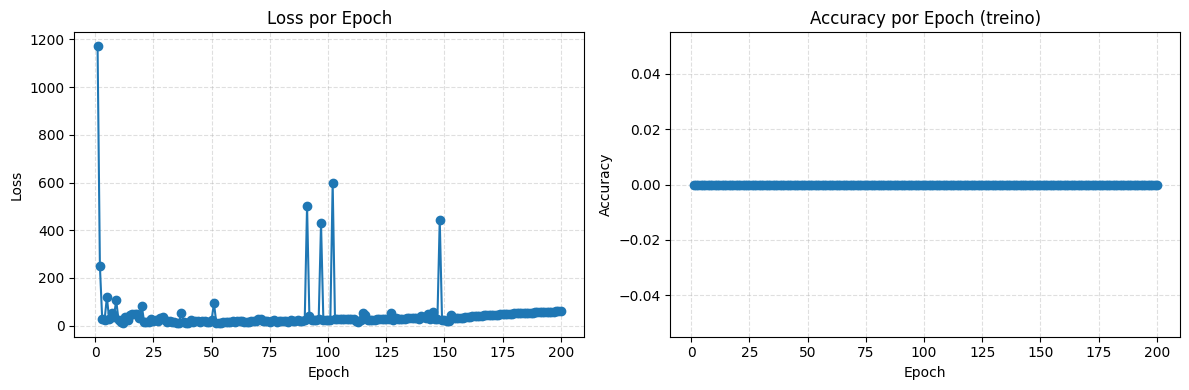

In [33]:
model.evaluate(X_test, y_test, plot_confusion=False, plot_roc=False, preds=preds_test)

# 8. Avaliação do modelo